# Exploration des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the dataset
train_data = pd.read_csv('dataset/train.csv')

In [3]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

emotionLabels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

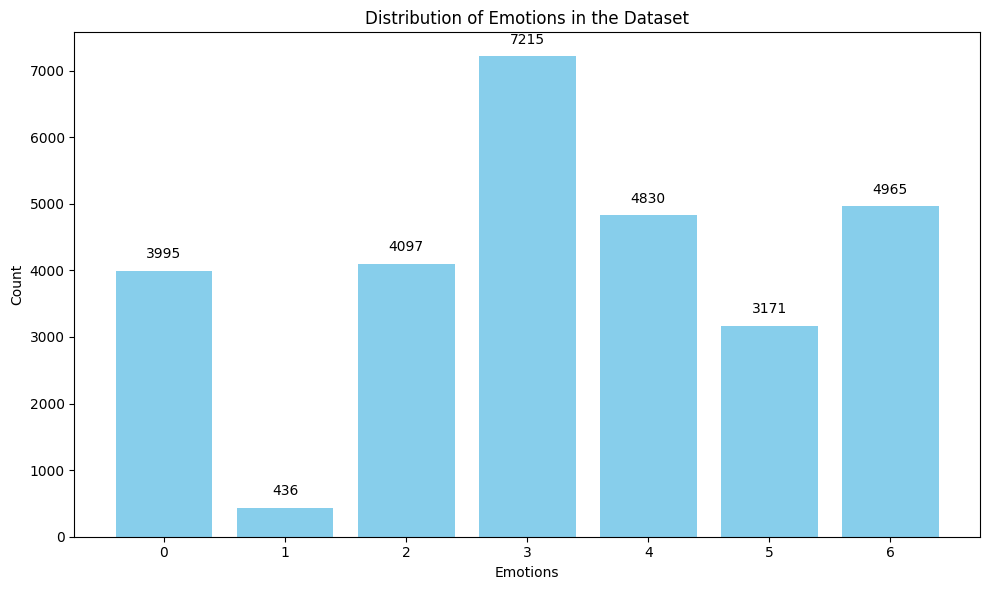

In [4]:
# Count the number of occurrences of each emotion

emotion_counts = train_data['emotion'].value_counts()

plt.figure(figsize=(10, 6))

plt.bar(emotion_counts.index, emotion_counts.values, color='skyblue')

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions in the Dataset')

for i, count in zip(emotion_counts.index, emotion_counts.values):
    plt.text(i, count + 0.02 * max(emotion_counts.values), str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


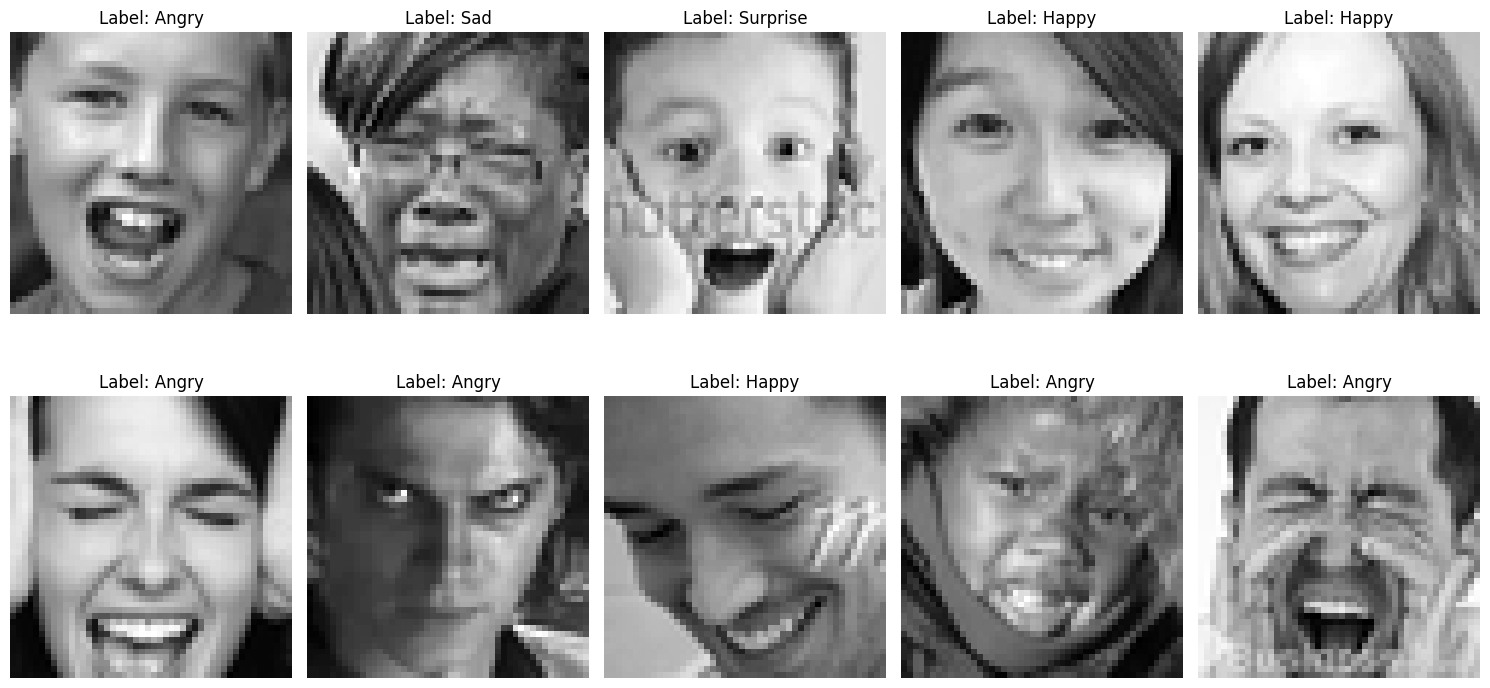

In [6]:
# Function to convert pixel string to image array
def pixels_to_image(pixels_str):
    pixels = np.array(pixels_str.split(), dtype='float32')  
    return pixels.reshape(48, 48)  # Reshape into 48x48 because the images are 48x48 pixels

# Display 10 random images
plt.figure(figsize=(15, 8))
for i in range(10):
    idx = np.random.randint(0, len(train_data))

    pixels = train_data.iloc[idx]['pixels']
    label = train_data.iloc[idx]['emotion']  

    # Convert pixels to image
    image = pixels_to_image(pixels)

    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {emotionLabels[label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Modèle CNN

## Objectif du modèle
On va créer un réseau de neurones convolutif avec
* En entrée des images de 48*48 pixels en niveau de gris (donc 1 canal)
* Apprendre à classifier ces images en 7 catégories (émotions de 0 -6)
* On va implémenter un modèle simple pour surtour focus sur l'analyse des optimiseurs

## Définir une architecture CNN de base
* 2 blocs convolution + activiation + maxpooling
* 1 couche Flattend
* 2 couches fully connected (MLP ) pour la classification finale

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()

        # 1er bloc convolution : 1 canal d'entrée (niveaux de gris) → 32 canaux
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # réduit 48x48 → 24x24
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        # 64 canaux, taille maintenue, puis pool → 12x12

        # Couche fully connected (après flatten)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # 64 maps de 12x12 → vecteur
        self.fc2 = nn.Linear(128, 7)             # 7 classes (émotions)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [1, 48, 48] → [32, 24, 24]
        x = self.pool(F.relu(self.conv2(x)))  # [64, 12, 12]
        x = x.view(-1, 64 * 12 * 12)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                        # Pas de softmax ici, car on utilisera CrossEntropyLoss
        return x


### Note
* Conv2d :  détecte des motifs locaux (bordeures, textures)
* RelU: Introduit la non-linéarité
* Maxpool2d: Réduit la taille donc les calculs, et garde les infos clés
* Linear: interprète les features extraits pour la classification

DONC:
- Entrée : 1 × 48 × 48 (1 canal = gris)

- Après 2 Conv + Pool : 64 × 12 × 12 → vectorisé (flatten) → vecteur de taille 9216

- Puis une couche dense (128 neurones), et sortie à 7 neurones (logits pour chaque émotion)

In [10]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchsummary import summary

model = EmotionCNN()


# Le résumé Format [channels, height, width] → ici [1, 48, 48]
summary(model, input_size=(1, 48, 48))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
         MaxPool2d-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Linear-5                  [-1, 128]       1,179,776
            Linear-6                    [-1, 7]             903
Total params: 1,199,495
Trainable params: 1,199,495
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.06
Params size (MB): 4.58
Estimated Total Size (MB): 5.64
----------------------------------------------------------------


## Préparation des DataLoarders

In [12]:
import pandas as pd

train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

In [13]:
from torch.utils.data import Dataset
import numpy as np
import torch

class FacialExpressionDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        pixels = np.fromstring(row['pixels'], dtype=np.float32, sep=' ').reshape(48, 48)
        pixels = pixels / 255.0  # Normalisation
        pixels = np.expand_dims(pixels, axis=0)  # [1, 48, 48]
        label = int(row['emotion'])

        return torch.tensor(pixels, dtype=torch.float32), label


In [15]:
from torch.utils.data import DataLoader

train_dataset = FacialExpressionDataset(train_df)
test_dataset = FacialExpressionDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

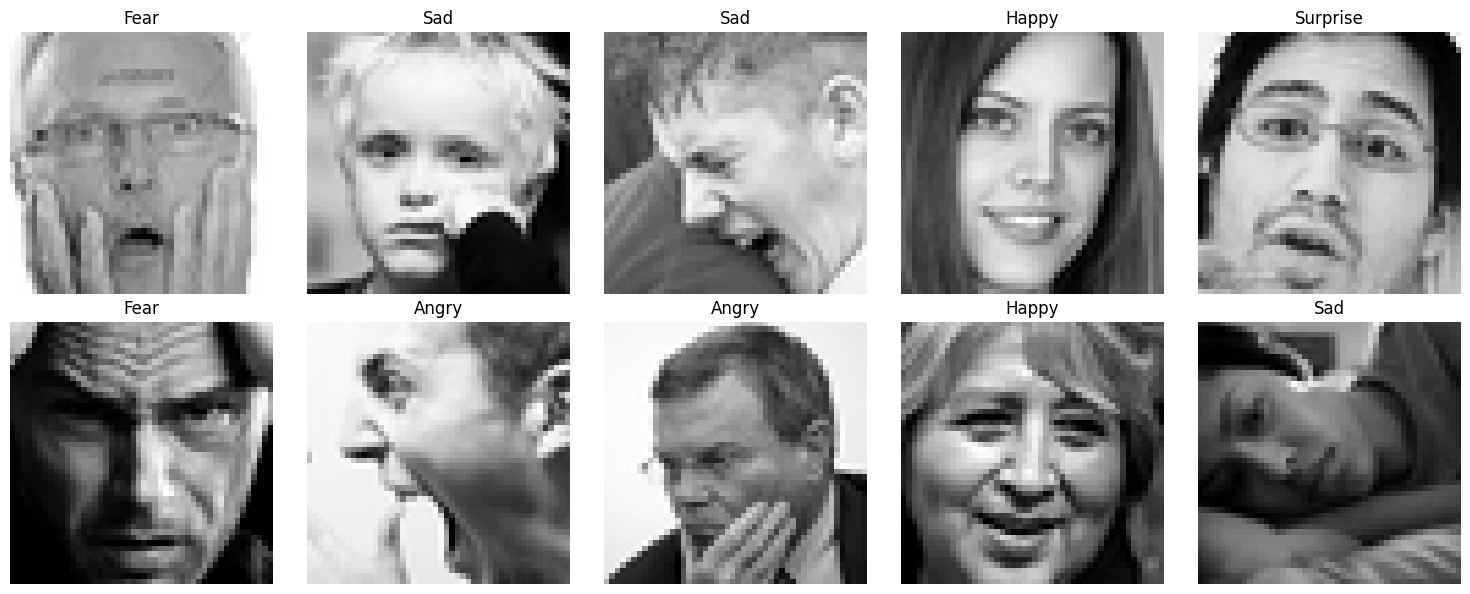

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Dictionnaire des labels
emotionLabels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Charger un batch depuis le train_loader
images, labels = next(iter(train_loader))

# Afficher les 10 premières images du batch
plt.figure(figsize=(15, 6))
for i in range(10):
    img = images[i][0].numpy()  # On enlève la dimension "canal" et convertit en numpy
    label = labels[i].item()

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(emotionLabels[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


## Optimiseur test: SGD

Objectif:

-Voir comment la loss évolue avec un optimiseur simple

-Tracer la courbe de perte

-Préparer le terrain pour la comparaison avec d’autres méthodes (Adam, momentum, etc.)

1. Qu’est-ce que l’optimisation dans ce projet ?

Dans le contexte de l’apprentissage automatique, l’optimisation consiste à minimiser une fonction de perte (par ex. CrossEntropyLoss) par rapport aux poids du réseau.

Formellement : On cherche à résoudre un problème du type
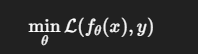


où :

* 𝜃= paramètres du modèle (poids, biais)

* 𝑓𝜃(𝑥)= prédiction du modèle
* L = fonction de perte (ici non convexe car CNN)

2. Premier optimiseur étudié : Stochastic Gradient Descent (SGD)

L'algorithme SGD est une méthode d'optimisation de premier ordre, c’est-à-dire qu’elle utilise le gradient (la dérivée) de la fonction de perte pour ajuster les poids du modèle.

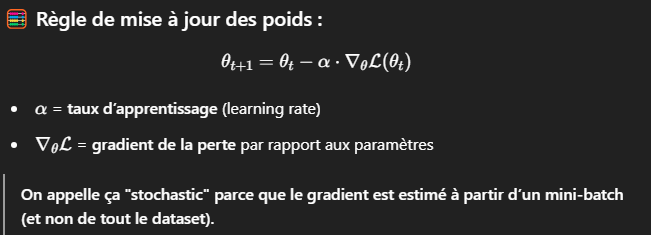

* ✅ Avantages de SGD

Simple à implémenter

Rapide par itération

Convergence vers un minimum local (souvent suffisant)

*  ❌ Inconvénients :
Peut osciller autour du minimum

Convergence lente si mal paramétré

Très sensible au choix du learning rate 𝛼


## Application du SGD sur CNN

SGD est une optimisation continue :

On optimise des poids réels via une méthode dérivée (descente de gradient)

Pas d’algorithmes discrets, tout est différentiable

Fonction de perte utilisée : CrossEntropyLoss
* Elle mesure l’écart entre les logits de sortie du modèle et les étiquettes de classe.

Cette fonction n’est pas convexe (important à dire dans le rapport), car :

* Le réseau est profond (non linéaire)

* Il y a des fonctions comme ReLU, softmax implicite, etc.

* Mais comme le gradient est calculable, les méthodes de descente comme SGD restent valables.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Vérifier si on utilise le GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialiser le modèle + fonction de perte + optimiseur
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()                      # log-loss pour classification
optimizer = optim.SGD(model.parameters(), lr=0.01)     # SGD avec learning rate α = 0.01

# Paramètres d'entraînement
n_epochs = 10
train_losses = []

# Boucle d'entraînement
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()               # Réinitialiser les gradients
        outputs = model(images)             # Forward pass
        loss = criterion(outputs, labels)   # Calcul de la loss
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Mise à jour des poids (SGD)

        running_loss += loss.item() * images.size(0)  # accumuler la perte

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}")


Epoch 1/10 - Loss: 1.8118
Epoch 2/10 - Loss: 1.7738
Epoch 3/10 - Loss: 1.7403
Epoch 4/10 - Loss: 1.7025
Epoch 5/10 - Loss: 1.6703
Epoch 6/10 - Loss: 1.6430
Epoch 7/10 - Loss: 1.6207
Epoch 8/10 - Loss: 1.6007
Epoch 9/10 - Loss: 1.5792
Epoch 10/10 - Loss: 1.5604


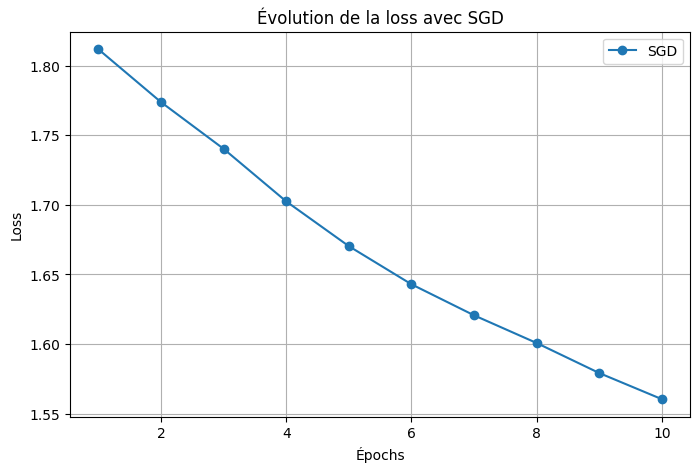

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs+1), train_losses, marker='o', label='SGD')
plt.title("Évolution de la loss avec SGD")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Interprétation de la courbe de loss avec SGD

📉 Observation :
La courbe décroît de manière continue et régulière entre l’époque 1 et 10.

La perte passe de ~1.81 à ~1.56 en 10 époques.

📌 Interprétation :
Cela montre que SGD apprend correctement : le réseau réduit l’erreur au fil des itérations.

Cependant, la courbe reste assez lente → la convergence n’est pas très rapide. -> Ca m'a pris 10 minutes 

🎯 C’est typique de SGD "pur", sans techniques avancées comme momentum ou adaptation de learning rate.

## Note sur la Cross entropy
CrossEntropyLoss elle-même est convexe par nature

Mais appliquée à un CNN, elle devient non convexe à cause :

* des ReLU

* des couches convolutives

* des combinations de couches non-linéaires

Mais comme la fonction reste différentiable presque partout, on peut utiliser des méthodes de 1er ordre comme SGD.

## Analyser l'impact des hyperparamètres

 On a entraîné un CNN avec SGD (α = 0.01) et observé une convergence progressive, il est temps d’explorer l’impact des hyperparamètres, comme ton prof l’exige, et de faire une vraie analyse d’optimisation.



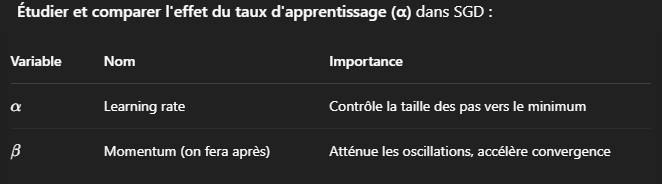

Le taux d’apprentissage 𝛼 détermine la vitesse avec laquelle les poids sont mis à jour. Un taux trop petit ralentit l’apprentissage, un taux trop grand peut empêcher la convergence.

## 3 trainings

### 1. Petit α = 0.001
* Convergence très lente

* Risque : le modèle n’apprend pas bien

In [32]:
#On garde tout identique sauf le lr dans :
# On fait 3 trainings:


optimizer = optim.SGD(model.parameters(), lr=0.001)



### 2. Trop grand α = 0.1
* Peut diverger ou osciller

* Risque : instabilité, la loss fait des hauts/bas ou augmente

In [33]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

### 3. Valeur de base α = 0.01 (déjà fait)
* Comportement raisonnablement stable

* Base de comparaison

In [34]:
def train_with_sgd(alpha):
    model = EmotionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=alpha)

    train_losses = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"α={alpha:.3f} - Epoch {epoch+1} - Loss: {epoch_loss:.4f}")
    
    return train_losses


α=0.001 - Epoch 1 - Loss: 1.8926
α=0.001 - Epoch 2 - Loss: 1.8268
α=0.001 - Epoch 3 - Loss: 1.8147
α=0.001 - Epoch 4 - Loss: 1.8119
α=0.001 - Epoch 5 - Loss: 1.8104
α=0.001 - Epoch 6 - Loss: 1.8091
α=0.001 - Epoch 7 - Loss: 1.8077
α=0.001 - Epoch 8 - Loss: 1.8063
α=0.001 - Epoch 9 - Loss: 1.8045
α=0.001 - Epoch 10 - Loss: 1.8028
α=0.010 - Epoch 1 - Loss: 1.8160
α=0.010 - Epoch 2 - Loss: 1.7866
α=0.010 - Epoch 3 - Loss: 1.7564
α=0.010 - Epoch 4 - Loss: 1.7262
α=0.010 - Epoch 5 - Loss: 1.7001
α=0.010 - Epoch 6 - Loss: 1.6750
α=0.010 - Epoch 7 - Loss: 1.6544
α=0.010 - Epoch 8 - Loss: 1.6362
α=0.010 - Epoch 9 - Loss: 1.6180
α=0.010 - Epoch 10 - Loss: 1.5997
α=0.100 - Epoch 1 - Loss: 1.7537
α=0.100 - Epoch 2 - Loss: 1.6079
α=0.100 - Epoch 3 - Loss: 1.4847
α=0.100 - Epoch 4 - Loss: 1.3845
α=0.100 - Epoch 5 - Loss: 1.2992
α=0.100 - Epoch 6 - Loss: 1.2264
α=0.100 - Epoch 7 - Loss: 1.1462
α=0.100 - Epoch 8 - Loss: 1.0596
α=0.100 - Epoch 9 - Loss: 0.9598
α=0.100 - Epoch 10 - Loss: 0.8542


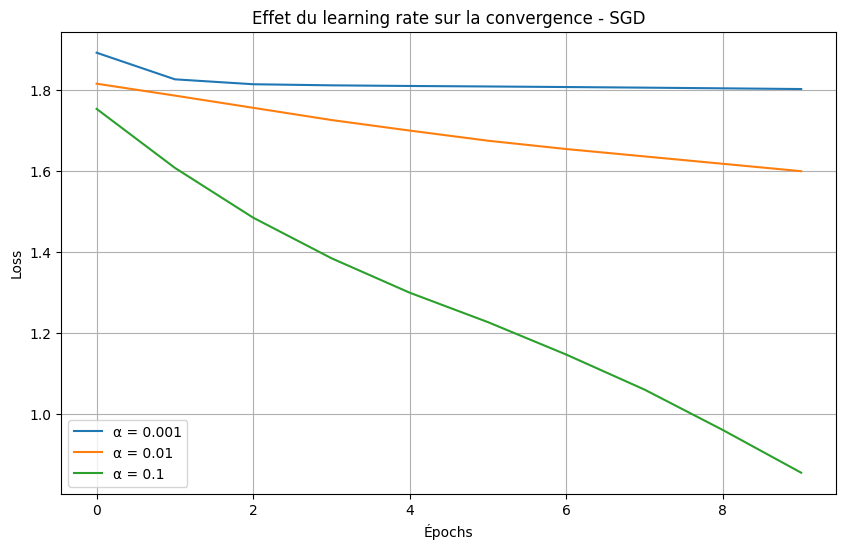

In [35]:
losses_001 = train_with_sgd(0.001)
losses_01 = train_with_sgd(0.01)
losses_1 = train_with_sgd(0.1)

plt.figure(figsize=(10, 6))
plt.plot(losses_001, label='α = 0.001')
plt.plot(losses_01, label='α = 0.01')
plt.plot(losses_1, label='α = 0.1')
plt.title("Effet du learning rate sur la convergence - SGD")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### Intéprétation après avoir varier la paramètre Alpha du SGD

🔵 α = 0.001 : courbe quasiment plate

🟠 α = 0.01 : descente régulière

🟢 α = 0.1 : descente rapide et constante

### 🔵 1. SGD avec α = 0.001

* Comportement : la loss diminue à peine, très lentement : 1.8926 → 1.8028

Interprétation :

* Le pas d’apprentissage est trop petit

* L’optimiseur fait de mini-pas, donc met beaucoup de temps à converger

* On risque d’avoir besoin de beaucoup plus d’époques

✅ Stable mais trop lent → inefficace en pratique

### 🟠 2. SGD avec α = 0.01 (valeur de référence)

* Comportement : la loss descend bien : 1.8160 → 1.5997

Interprétation :

* Bon compromis entre vitesse et stabilité

* Permet de s’approcher du minimum en un nombre d’époques raisonnable

✅ C’est une valeur standard souvent utilisée en pratique avec SGD

### 🟢 3. SGD avec α = 0.1

* Comportement : la loss descend très vite : 1.7537 → 0.8542

Interprétation :

* Convergence très rapide

* Ici, le learning rate est efficace mais pas trop grand → pas d'instabilité

* On aurait pu avoir des oscillations, mais ici le modèle les a bien tolérées

✅ Très bonne performance dans ce cas précis, mais risqué sur d’autres datasets plus sensibles

CONCLUSION sur l'Optimisation
➤ 1. Le taux d’apprentissage 𝛼 est critique
* Trop bas → sous-apprentissage

* Trop haut → instabilité ou divergence (pas vu ici, mais possible dans d'autres cas)

➤ 2. La fonction de perte n’est pas convexe
* Donc il n’y a aucune garantie d’atteindre le minimum global

* Mais grâce à la descente de gradient et une bonne valeur de α, on peut trouver un minimum local acceptable

Ce comportement est accentué par la non-convexité de la fonction de perte (due à la structure CNN), mais SGD permet tout de même de converger vers des minima locaux valides.

La fonction de perte étant non convexe, plusieurs minima locaux peuvent exister.
Le choix du taux d’apprentissage ou du moment (momentum) a une influence importante sur la capacité de l’algorithme à atteindre un minimum local performant, sans rester bloqué dans un sous-optimum.

## Variation sur le momentum : beta

Le momentum est une méthode visant à améliorer la descente de gradient en ajoutant une composante inertielle.
Au lieu de s'appuyer uniquement sur le gradient actuel, l'algorithme cumule l'historique des gradients pour suivre une trajectoire plus fluide.
Cela permet une meilleure stabilité, une convergence plus rapide, et une meilleure robustesse face à la non-convexité de la fonction de perte.

On a fait varier alpha, le learning rate, maintenant on joue sur Beta, le momentum

🎓 1. Intuition simple
Imagine une balle qui roule dans une vallée ⛰️ :

* Sans friction → elle va accélérer dans la pente

* Si elle atteint un creux (minimum local), l’élan accumulé peut l’aider à le dépasser et continuer vers un minimum plus bas

🎯 C’est exactement ça que le momentum fait en optimisation :

Il ajoute une mémoire du passé pour ne pas s'arrêter trop vite et gagner de la vitesse dans la bonne direction.

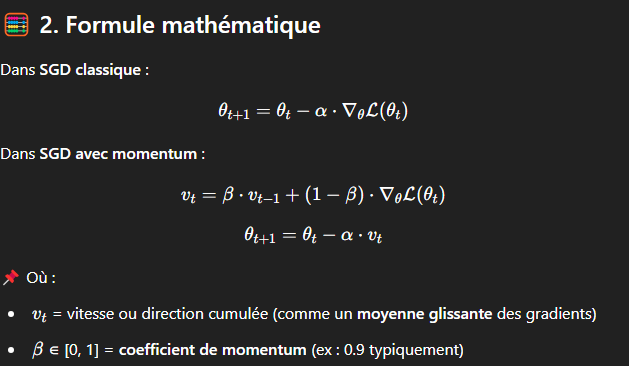

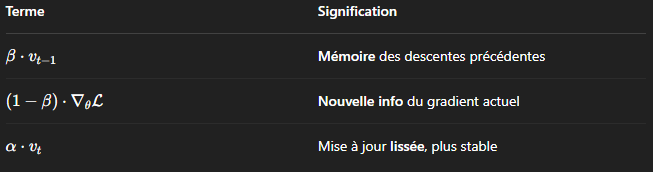

4. Comportement attendu
* Plus fluide : moins d’oscillations, surtout quand la pente change brutalement

* Plus rapide : car l'optimiseur accumule de la vitesse dans la "bonne" direction

* Moins sensible à de petits minimums locaux

Grâce au momentum dans notre CNN:

* On évite de trop ralentir dans les régions plates de la loss

* On peux sauter des minima locaux (faibles creux)

* On accélères la convergence sans augmenter 𝛼


### Entrainement SGD + MOMENTUM

#### Momentum = 0.9

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialiser modèle
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # momentum ici

# Entraînement
n_epochs = 10
train_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Momentum 0.9 - Epoch {epoch+1} - Loss: {epoch_loss:.4f}")


Momentum 0.9 - Epoch 1 - Loss: 1.7775
Momentum 0.9 - Epoch 2 - Loss: 1.6337
Momentum 0.9 - Epoch 3 - Loss: 1.5277
Momentum 0.9 - Epoch 4 - Loss: 1.4221
Momentum 0.9 - Epoch 5 - Loss: 1.3437
Momentum 0.9 - Epoch 6 - Loss: 1.2683
Momentum 0.9 - Epoch 7 - Loss: 1.1906
Momentum 0.9 - Epoch 8 - Loss: 1.1191
Momentum 0.9 - Epoch 9 - Loss: 1.0291
Momentum 0.9 - Epoch 10 - Loss: 0.9382


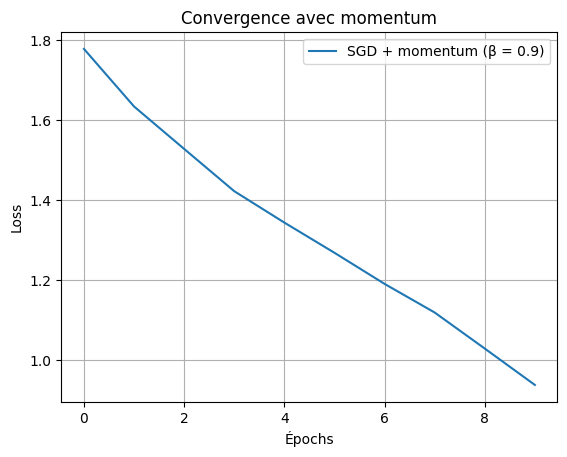

In [37]:
plt.plot(train_losses, label='SGD + momentum (β = 0.9)')
plt.title("Convergence avec momentum")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

####  Interprétation : SGD avec momentum (β = 0.9)

* une courbe très régulière et une perte qui chute rapidement

* La loss passe de 1.77 → 0.93 en 10 époques 

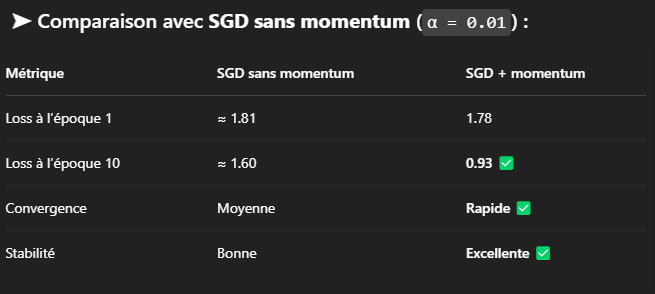

L’ajout d’un momentum (β = 0.9) a permis :

* D’accélérer la convergence

* De lisser les descentes du gradient

* D’atteindre une perte plus faible en moins de temps

Cela s’explique par le fait que l’optimiseur accumule l’historique des gradients pour renforcer les directions constantes et atténuer les variations instables (paliers, rebonds, petits minimums).

IMPACT SUR LA NON CONVEXITE :
* Grâce au momentum, l’optimisation est moins affectée par les minima locaux. L’élan accumulé permet au modèle de ne pas "rester coincé" dans des vallées peu profondes.

CONCLUSION pour B= 0.9
* Momentum est un ajout simple mais très efficace à SGD

* Il n'améliore pas la fonction de perte elle-même, mais l'algorithme qui cherche son minimum

* Dans des cas non convexes (comme ici avec un CNN), il est souvent essentiel pour de bonnes performances

### Comparaison de β dans SGD + momentum

On va tester :

🟡 β = 0.5 → peu de mémoire (momentum faible)

🔵 β = 0.9 → valeur standard (déjà fait)

🔴 β = 0.99 → presque que de l’élan

In [39]:
def train_with_momentum(beta):
    model = EmotionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=beta)

    train_losses = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"β = {beta:.2f} - Epoch {epoch+1} - Loss: {epoch_loss:.4f}")
    
    return train_losses


In [40]:
n_epochs = 10

losses_05 = train_with_momentum(0.5)
losses_09 = train_with_momentum(0.9)
losses_099 = train_with_momentum(0.99)

β = 0.50 - Epoch 1 - Loss: 1.8173
β = 0.50 - Epoch 2 - Loss: 1.7779
β = 0.50 - Epoch 3 - Loss: 1.7223
β = 0.50 - Epoch 4 - Loss: 1.6573
β = 0.50 - Epoch 5 - Loss: 1.6185
β = 0.50 - Epoch 6 - Loss: 1.5908
β = 0.50 - Epoch 7 - Loss: 1.5635
β = 0.50 - Epoch 8 - Loss: 1.5359
β = 0.50 - Epoch 9 - Loss: 1.5095
β = 0.50 - Epoch 10 - Loss: 1.4797
β = 0.90 - Epoch 1 - Loss: 1.7597
β = 0.90 - Epoch 2 - Loss: 1.6149
β = 0.90 - Epoch 3 - Loss: 1.5098
β = 0.90 - Epoch 4 - Loss: 1.4105
β = 0.90 - Epoch 5 - Loss: 1.3349
β = 0.90 - Epoch 6 - Loss: 1.2604
β = 0.90 - Epoch 7 - Loss: 1.1936
β = 0.90 - Epoch 8 - Loss: 1.1185
β = 0.90 - Epoch 9 - Loss: 1.0338
β = 0.90 - Epoch 10 - Loss: 0.9337
β = 0.99 - Epoch 1 - Loss: 1.7517
β = 0.99 - Epoch 2 - Loss: 1.6214
β = 0.99 - Epoch 3 - Loss: 1.5997
β = 0.99 - Epoch 4 - Loss: 1.5706
β = 0.99 - Epoch 5 - Loss: 1.5908
β = 0.99 - Epoch 6 - Loss: 1.5535
β = 0.99 - Epoch 7 - Loss: 1.5273
β = 0.99 - Epoch 8 - Loss: 1.5151
β = 0.99 - Epoch 9 - Loss: 1.4994
β = 0.99 - E

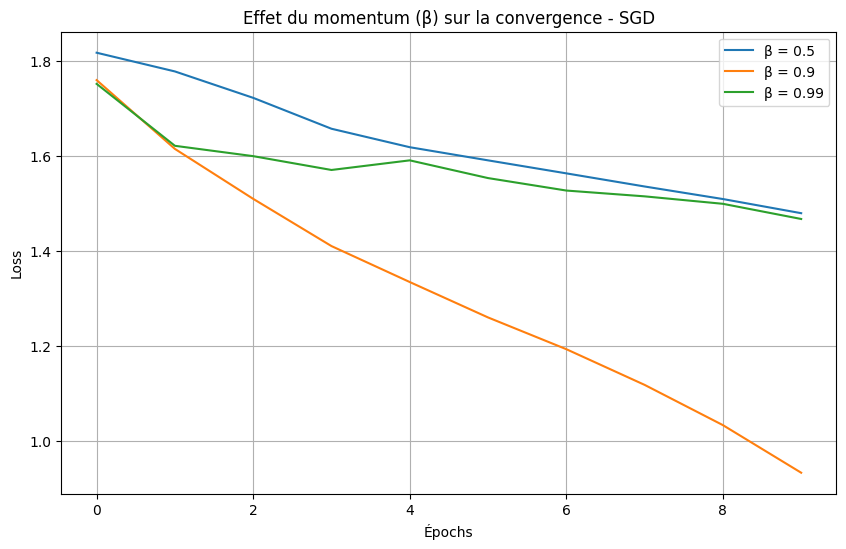

In [41]:
plt.figure(figsize=(10,6))
plt.plot(losses_05, label='β = 0.5')
plt.plot(losses_09, label='β = 0.9')
plt.plot(losses_099, label='β = 0.99')
plt.title("Effet du momentum (β) sur la convergence - SGD")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Interpretation

🔵 β = 0.5 → courbe lente mais stable

🟠 β = 0.9 → meilleure descente

🟢 β = 0.99 → instable (rebondit au lieu de descendre)

##### Pour β = 0.5 → momentum faible

* Loss : 1.81 → 1.48
✅ Stable	
❌ Convergence lente
* L’effet du momentum est limité.

* Le modèle progresse, mais lentement.

* Il agit un peu comme un SGD classique avec juste un léger lissage.


#### 🟠 β = 0.9 → momentum standard (optimal ici)

* Loss : 1.75 → 0.93
 
* Très bonne vitesse	

* Courbe régulière et sans rebonds	


- Le compromis idéal entre mémoire du gradient et stabilité.

- L’optimiseur garde l’élan sans surcorrections.

- Meilleure convergence dans ce contexte

#### 🟢 β = 0.99 → momentum trop fort

* Loss : 1.75 → 1.46

⚠️ Oscillations visibles	
❌ Pas de gain clair sur la convergence

* Le momentum est trop important : il domine le gradient actuel.

* L’optimiseur continue sur sa lancée même si le gradient change → rebonds, stagnation ou divergence locale.

* Perte d’efficacité à cause de "sur-inertie"


### CONCLUSION
Nous avons testé plusieurs valeurs du paramètre β (momentum) dans l’optimiseur SGD.
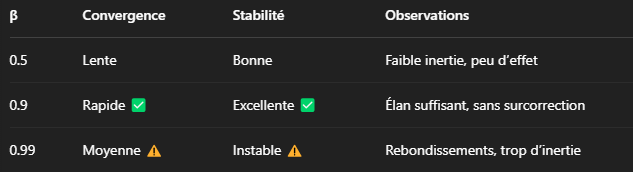

Un momentum de 0.9 s’est révélé optimal, améliorant significativement la descente de gradient, tout en maintenant une trajectoire stable.
Un momentum trop fort (0.99) entraîne une perte de contrôle de la direction de descente, et peut même empêcher la convergence vers un minimum local efficace.

## Etapes finale: Fixer les meilleurs paramètres et ré entraîner le modèle

SGD + momentum

α = 0.1 (learning rate)

β = 0.9 (momentum)

Plus d’époques (ex. 20) pour une convergence complète

[1/20] - Loss: 1.7366
[2/20] - Loss: 1.6574
[3/20] - Loss: 1.6286
[4/20] - Loss: 1.6016
[5/20] - Loss: 1.5583
[6/20] - Loss: 1.5320
[7/20] - Loss: 1.4981
[8/20] - Loss: 1.4664
[9/20] - Loss: 1.5200
[10/20] - Loss: 1.5172
[11/20] - Loss: 1.5112
[12/20] - Loss: 1.4509
[13/20] - Loss: 1.3973
[14/20] - Loss: 1.4039
[15/20] - Loss: 1.3802
[16/20] - Loss: 1.3337
[17/20] - Loss: 1.3439
[18/20] - Loss: 1.2976
[19/20] - Loss: 1.2635
[20/20] - Loss: 1.2751


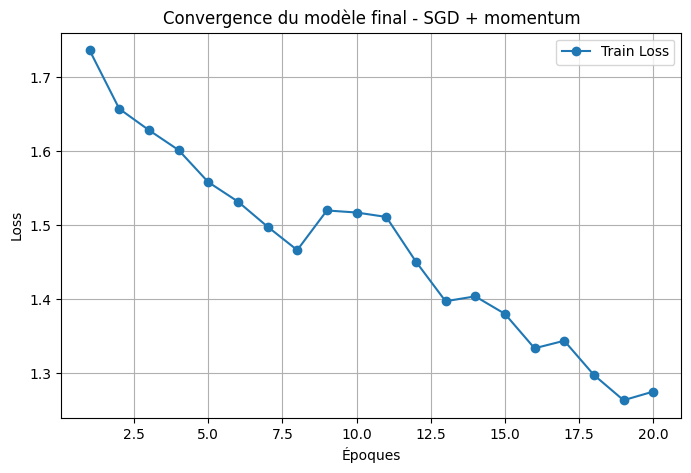

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # valeurs optimales

n_epochs = 20
train_losses = []

# 2. Entraînement
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    print(f"[{epoch+1}/{n_epochs}] - Loss: {epoch_loss:.4f}")

# 3. Courbe de perte
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), train_losses, marker='o', label='Train Loss')
plt.title("Convergence du modèle final - SGD + momentum")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


### Observation
* Convergence continue : la loss diminue globalement de 1.73 → 1.27

* Quelques petites oscillations locales (époques 9–11, 13–14) → normales sur une fonction non convexe

* Mais la tendance est clairement descendante

L’optimisation finale du CNN avec SGD + momentum (α = 0.1, β = 0.9) a permis une convergence stable sur 20 époques, atteignant une perte de 1.27.
Cette configuration, validée expérimentalement, offre le meilleur compromis entre vitesse, stabilité et profondeur de descente.

In [44]:
def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total


In [46]:
from sklearn.model_selection import train_test_split

# Split 80% entraînement / 20% validation
train_split_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Dataset personnalisés
train_dataset = FacialExpressionDataset(train_split_df)
val_dataset = FacialExpressionDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [48]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)

print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")



Train Accuracy: 54.99%
Validation Accuracy: 54.96%


In [50]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


              precision    recall  f1-score   support

       Angry       0.52      0.39      0.45       750
     Disgust       0.71      0.23      0.34        75
        Fear       0.50      0.43      0.46       831
       Happy       0.66      0.73      0.69      1471
         Sad       0.46      0.45      0.46       989
    Surprise       0.80      0.55      0.65       640
     Neutral       0.44      0.63      0.52       986

    accuracy                           0.55      5742
   macro avg       0.58      0.49      0.51      5742
weighted avg       0.56      0.55      0.55      5742



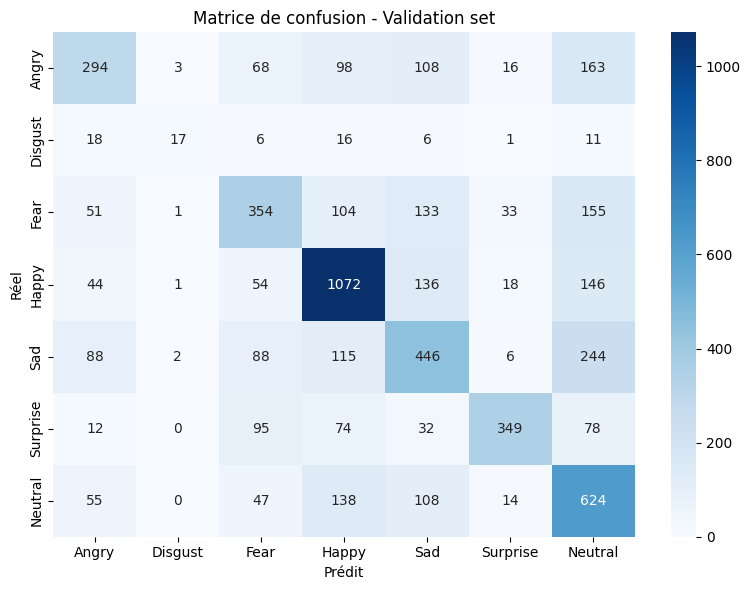

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Labels texte pour les classes
emotionLabels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear',
    3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

# Récupérer toutes les vraies valeurs et prédictions
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Évaluer sur le validation set
true_labels, predicted_labels = evaluate_model(model, val_loader)

# Afficher classification report
print(classification_report(true_labels, predicted_labels, target_names=emotionLabels.values()))

# Matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotionLabels.values(),
            yticklabels=emotionLabels.values())
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Validation set")
plt.tight_layout()
plt.show()


✅ Bonnes performances :
* Happy : recall à 73 %, le modèle la reconnaît bien (sûrement des traits faciaux forts)

* Neutral : recall à 63 %

* Surprise : très bon f1-score de 65%

❌ Plus difficile :
* Disgust et Angry sont mal reconnus → peu de données + confusion visuelle

* Beaucoup de confusion entre Sad, Fear et Neutral (classique)

Donc: Certaines classes sont plus difficiles à distinguer, en particulier Sad, Fear et Angry, probablement à cause de similarités visuelles et d’un déséquilibre dans le dataset.

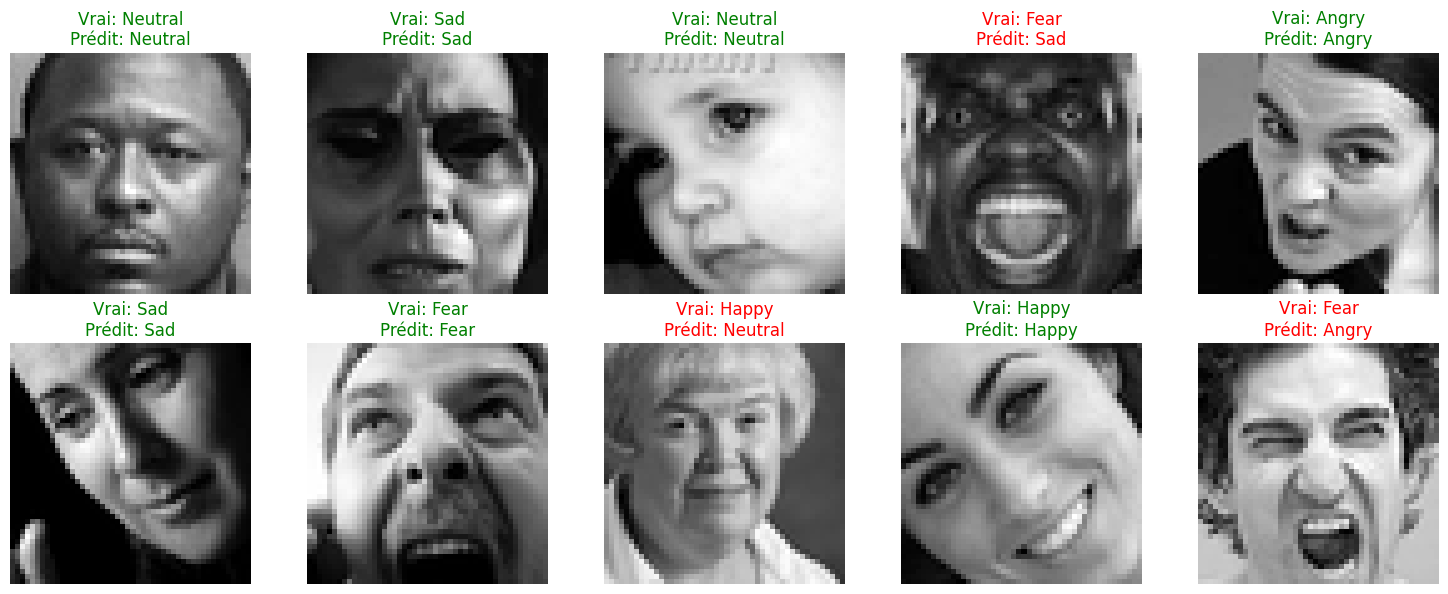

In [52]:
# Afficher des images avec leur vraie étiquette + prédiction
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

plt.figure(figsize=(15, 6))
for i in range(10):
    img = images[i][0].cpu().numpy()
    true_label = emotionLabels[labels[i].item()]
    pred_label = emotionLabels[preds[i].item()]
    color = "green" if true_label == pred_label else "red"

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Vrai: {true_label}\nPrédit: {pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()
